Image Diffusion Quantization Project

In [1]:
## Make sure we have a GPU available
!nvidia-smi

Fri Nov 14 16:16:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.32                 Driver Version: 581.32         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P3             21W /   45W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Authenticate to Hugging Face and get model access

Login to huggingface and make sure you have gained access to the LLama-3.2-1B-Instruct model. Acces can be gained at [huggingface](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) by clicking on the "Request Access" button. After you have access, you can use the code below to download the model and tokenizer.

In [2]:
# Load Hugging Face API key from environment (do NOT hardcode your token here).
import os
import logging, warnings
from transformers import logging as hf_logging

# Silence transformers/TRL logs early
hf_logging.set_verbosity_error()
logging.getLogger("trl").setLevel(logging.ERROR)

# Hide specific noisy warnings
warnings.filterwarnings(
    "ignore",
    message=r".*loss_type=None.*ForCausalLMLoss.*",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",
    message=r".*cuDNN SDPA backward got grad_output\.strides\(\) != output\.strides\(\).*",
    category=UserWarning,
)
os.environ["TQDM_NOTEBOOK"] = "0"  

from huggingface_hub import login
from dotenv import load_dotenv

# Load .env file (if present)
load_dotenv()
hf_key = os.environ.get("HUGGINGFACE_API_KEY")
if hf_key:
    login(hf_key)
else:
    raise EnvironmentError("HUGGINGFACE_API_KEY not found. Copy .env.template to .env and add your token. See Instruction.md")

C:\Users\mtgra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


STABLE DIFFUSION

In [3]:
#LOAD SD MODEL
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
  


Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


LLAMA

In [ ]:
# LLAMA SETUP

from transformers import (
    AutoModelForCausalLM, # imports the model for causal language modeling
    AutoTokenizer, # imports the tokenizer for the model
    pipeline # imports the pipeline for text generation
)

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Sets the CUDA device to use
device = torch.device('cuda:0') # Creates a CUDA device object
import random
random.seed(22) # Sets the random seed for reproducibility

import copy

sft_model_name = 'meta-llama/Llama-3.2-1B-Instruct'  # No quantization
sft_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=sft_model_name,
    torch_dtype=torch.float16,  # No quantization
    low_cpu_mem_usage=True,
)
base_model = copy.deepcopy(sft_model)  # Keep a copy of the base model for evaluation
sft_tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=sft_model_name,
)
sft_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

generator = pipeline( # Creates a text generation pipeline
    'text-generation',
    model=sft_model,
    tokenizer=sft_tokenizer,
    # pad_token_id=sft_tokenizer.eos_token_id,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.8,
    top_p=0.95,
)



In [ ]:
#PROMPT GENERATION

subject_instruction = "Provide one random English noun. Respond with exactly one tokenizable word."
inputs = generator.tokenizer(subject_instruction, return_tensors="pt").to("cuda")
subject = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)
#Hacky fix to strip instruction (instrction length plus model output formatting length)
subject = subject[len(subject_instruction)+17:len(subject)]

action_instruction = "Provide one random activity. Respond with exactly one tokenizable word."
inputs = generator.tokenizer(action_instruction, return_tensors="pt").to("cuda")
action = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)
#Hacky fix to strip instruction (instrction length plus model output formatting length)
action = action[len(action_instruction)+17:len(action)]

instruction = f"Describe a scene in which a {subject} is {action}."

print(instruction)

inputs = generator.tokenizer(instruction, return_tensors="pt").to("cuda")
prompt = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)

#Hacky fix to strip instruction (instrction length plus model output formatting length)
prompt = prompt[len(instruction)+17:len(prompt)]

print(prompt)

Describe a scene in which a  The noun is: cloud

Your turn!<|eot_id|> is  
Activity: 
Glow-in-the-Dark Painting
 
Go!<|eot_id|>.
<|eot_id|>


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


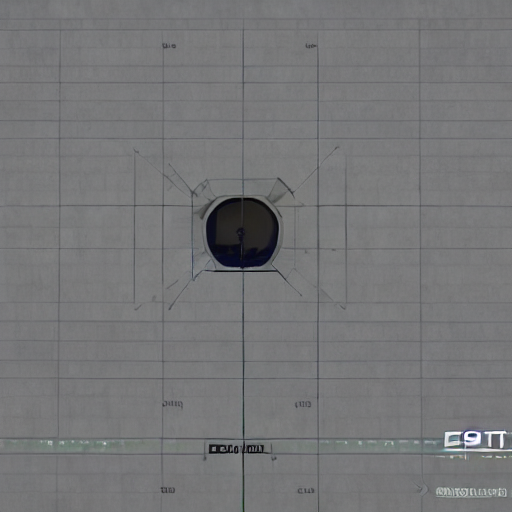

In [58]:
image = pipe(prompt).images[0]  
display(image)

#image.save("name.png")

In [ ]:
#PROMPT GENERATION BULK

def BulkGenerateLoad(NumberOfUsers, NumberOfRequestsPerUser):

    RequestList = [[0 for _ in range(NumberOfRequestsPerUser)] for _ in range(NumberOfUsers)]

   
    for row in range(NumberOfUsers):
        for col in range(NumberOfRequestsPerUser):
            
            subject_instruction = "Provide one random English noun. Respond with exactly one tokenizable word."
            inputs = generator.tokenizer(subject_instruction, return_tensors="pt").to("cuda")
            inputs["input_ids"] = inputs["input_ids"][:, :100]
            subject = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)
            #Hacky fix to strip instruction (instrction length plus model output formatting length)
            subject = subject[len(subject_instruction)+17:len(subject)]

            action_instruction = "Provide one random activity. Respond with exactly one tokenizable word."
            inputs = generator.tokenizer(action_instruction, return_tensors="pt").to("cuda")
            inputs["input_ids"] = inputs["input_ids"][:, :100]
            action = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)
            #Hacky fix to strip instruction (instrction length plus model output formatting length)
            action = action[len(action_instruction)+17:len(action)]

            instruction = f"Describe a scene in which a {subject} is {action}."

            inputs = generator.tokenizer(instruction, return_tensors="pt").to("cuda")
            inputs["input_ids"] = inputs["input_ids"][:, :100]
            prompt = generator.tokenizer.decode(generator.model.generate(**inputs, max_new_tokens=100)[0],return_dict_in_generate=True)

            #Hacky fix to strip instruction (instrction length plus model output formatting length)
            prompt = prompt[len(instruction)+17:len(prompt)]

            RequestList[row][col] = prompt

  
    return RequestList





Describe a scene in which a  

eagle

butterfly

pineapple

computer

house

bookshelf

kitten

sugar

guitar

toothbrush

umbrella

space

cloud

helmet

toaster

banana

chair

fish

kale

water

garden

muffin

carrot

apple

pencil

book

piano

lemon

silk

piano

paper

knife

orange

nail

toilet

shower

b is  TAT

Milkshake
Eggplant
Bicycle
Piano
Couch
Soccer
Guitar
Fountain
Tennis
Bread
Piano
Muffin
Lunch
Dinner
Bike
Towel
Pencil
Egg
Tennis
Piano
Bread
Soccer
Fountain
Lunch
Couch
Towel
Bicycle
Guitar
Muffin
Egg
Piano
.
Describe a scene in which a  "The".


The. Word: clock.<|eot_id|> is  
The cat sat on the windowsill. 
Cat sat on the windowsill. 
The cat sat on the windowsill. 
The cat sat on the windowsill. 

The cat sat on the windowsill. 
The cat sat on the windowsill. 
The cat sat on the windowsill. 
The cat sat on the windowsill. 
The cat sat on the windowsill. 
The cat sat on the windowsill. 

The cat sat on the windowsill. 
The.
Describe a scene in which a  
Word: Fid

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the windowsill .']


[['\nchair\n\numbrella\n\nspace\n\ncloud\n\nhelmet\n\ntoaster\n\nbanana\n\n', 'cat sat on the windowsill. \nThe cat sat on the windowsill. \nThe cat sat on the windowsill. \n\nThe cat sat on the windowsill. \nThe cat sat on the windowsill. \nThe cat sat on the windowsill. \nThe cat sat on the windowsill. \nThe cat sat on the windowsill. \n\nThe cat sat on the windowsill. \n'], ['r\ncherry\napple\nlemon\ntuna\nchicken\ntiger\nbicycle\nbookshelf\njacket\npiano\nsilk\nmango\nchicken\ntiger\nwaterfall\nnapkin\nbookshelf\nbicycle\nkitten\nfish\nguitar\nh', '<|eot_id|>']]


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


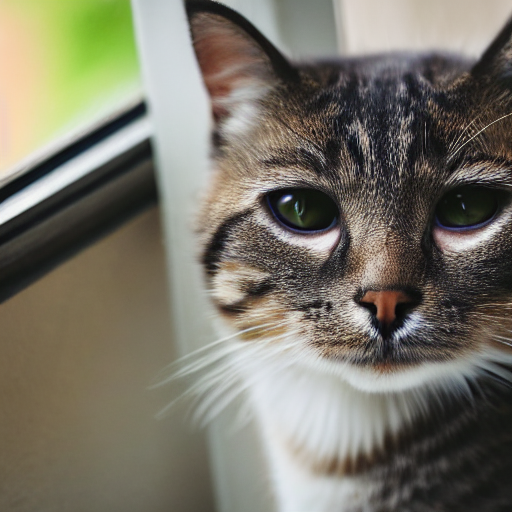

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


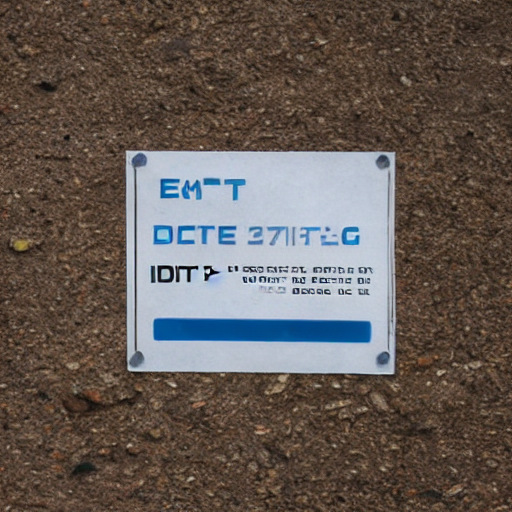

In [49]:
Users = 2
RequestsPerUser = 2

NewGeneratedList = BulkGenerateLoad(Users, RequestsPerUser)
# print(NewGeneratedList)

for i in range(Users):
    image = pipe(NewGeneratedList[i][1]).images[0]  
    display(image)

To Do List:

- Tweak Prompt generation quality (It doesn't respond with 1 word answers like I asked. I think a chat template, and maybe fine tuning might be needed, but more research to know for sure)
- Add Quantization for llama and stable diffusion models to call when queue gets too large
- create a simulation script with some random number of loops, users, requests per user (Modify the above test)
- add a quantization manager to that script that checks queue size (NewGeneratedList) and if above some threshold uses quantized model instead of based stable diffusion model
- Save prompts, images, processing times for analysis to a folder